In [2]:
import sys, os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import pandas as pd
import numpy as np

from src.data_loader import load_pbp_season, filter_falcons_offense
from src.preprocess import DrivePreprocessor
from src.clustering import DriveClusterer

In [4]:
df16 = load_pbp_season("../data/raw/pbp_2016.csv.gz")
df23 = load_pbp_season("../data/raw/pbp_2023.csv.gz")

In [5]:
falcons16 = filter_falcons_offense(df16)
falcons23 = filter_falcons_offense(df23)

In [6]:
falcons16.shape, falcons23.shape

((1565, 372), (1424, 372))

In [7]:
processor = DrivePreprocessor()

drives16 = processor.transform(falcons16)
drives23 = processor.transform(falcons23)

drives16.head()

,game_id,drive,play_count,run_pct,pass_pct,success_rate,avg_epa,start_yardline,end_yardline,drive_result,field_pos_gain
0,2016_01_TB_ATL,1.0,5,0.400000,0.200000,0.000000,-0.697290,NaN,NaN,Punt,NaN
1,2016_01_TB_ATL,3.0,6,0.000000,0.666667,0.333333,0.211043,NaN,NaN,Field goal,NaN
2,2016_01_TB_ATL,5.0,4,0.500000,0.250000,0.250000,-0.537614,NaN,NaN,Punt,NaN
3,2016_01_TB_ATL,7.0,7,0.142857,0.428571,0.714286,0.251765,NaN,NaN,Touchdown,NaN
4,2016_01_TB_ATL,9.0,8,0.375000,0.375000,0.250000,-0.219990,NaN,NaN,Punt,NaN


In [8]:
clusterer = DriveClusterer()

clusterer.fit(drives16)

clusterer.best_k, clusterer.get_k_scores()

(3,
 2    0.269526
 3    0.299844
 4    0.267772
 5    0.276970
 6    0.244703
 7    0.247722
 8    0.253925
 dtype: float64)

In [9]:
drives16_clust = clusterer.assign_clusters(drives16)
drives23_clust = clusterer.assign_clusters(drives23)

drives16_clust.head()

,game_id,drive,play_count,run_pct,pass_pct,success_rate,avg_epa,start_yardline,end_yardline,drive_result,field_pos_gain,cluster
0,2016_01_TB_ATL,1.0,5,0.400000,0.200000,0.000000,-0.697290,NaN,NaN,Punt,NaN,0
1,2016_01_TB_ATL,3.0,6,0.000000,0.666667,0.333333,0.211043,NaN,NaN,Field goal,NaN,2
2,2016_01_TB_ATL,5.0,4,0.500000,0.250000,0.250000,-0.537614,NaN,NaN,Punt,NaN,0
3,2016_01_TB_ATL,7.0,7,0.142857,0.428571,0.714286,0.251765,NaN,NaN,Touchdown,NaN,1
4,2016_01_TB_ATL,9.0,8,0.375000,0.375000,0.250000,-0.219990,NaN,NaN,Punt,NaN,0


In [10]:
centers = clusterer.get_cluster_centers()
centers

,play_count,run_pct,pass_pct,success_rate,avg_epa,cluster
0,4.980000,0.491738,0.194889,0.267611,-0.278553,0
1,9.609091,0.316205,0.449995,0.612496,0.454186,1
2,4.808511,0.093161,0.624544,0.235368,-0.709167,2


In [11]:
drives16_clust["cluster"].value_counts(normalize=True)
drives23_clust["cluster"].value_counts(normalize=True)

1    0.375635
2    0.324873
0    0.299492
Name: cluster, dtype: float64

In [12]:
drives16_clust.to_csv("../data/processed/falcons_drives_2016.csv", index=False)
drives23_clust.to_csv("../data/processed/falcons_drives_2023.csv", index=False)
centers.to_csv("../data/processed/cluster_centers.csv", index=False)

In [13]:
drives16_clust["cluster"].value_counts(normalize=True)

1    0.531401
0    0.241546
2    0.227053
Name: cluster, dtype: float64

In [14]:
drives23_clust["cluster"].value_counts(normalize=True)

1    0.375635
2    0.324873
0    0.299492
Name: cluster, dtype: float64

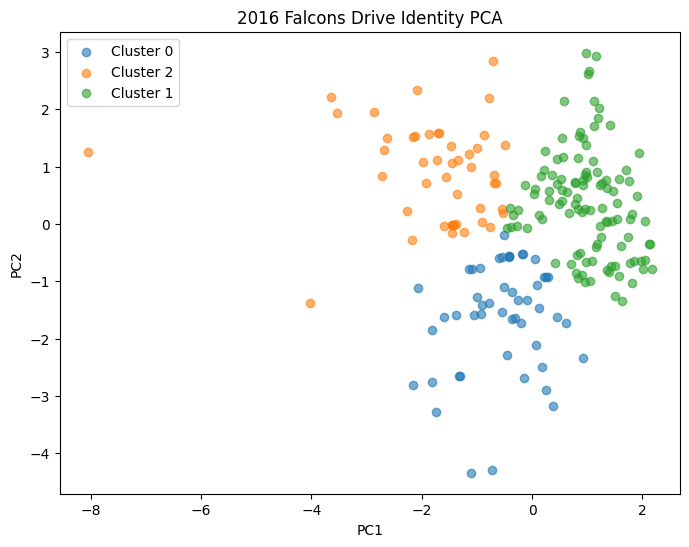

In [15]:
from src.pca_analysis import DrivePCA
import matplotlib.pyplot as plt

pca = DrivePCA()

# Fit PCA on 2016 drives (baseline identity space)
drives16_pca = pca.fit_transform(drives16_clust)

plt.figure(figsize=(8,6))
for c in drives16_pca["cluster"].unique():
    subset = drives16_pca[drives16_pca["cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.6)

plt.title("2016 Falcons Drive Identity PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

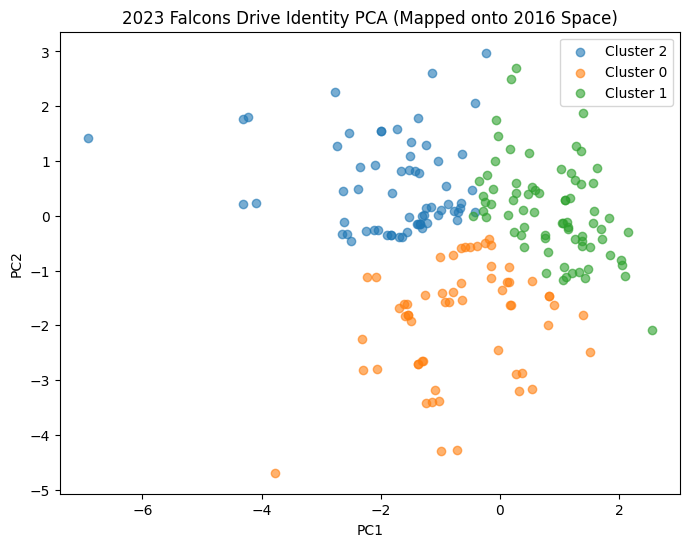

In [16]:
drives23_pca = pca.transform(drives23_clust)

plt.figure(figsize=(8,6))
for c in drives23_pca["cluster"].unique():
    subset = drives23_pca[drives23_pca["cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.6)

plt.title("2023 Falcons Drive Identity PCA (Mapped onto 2016 Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


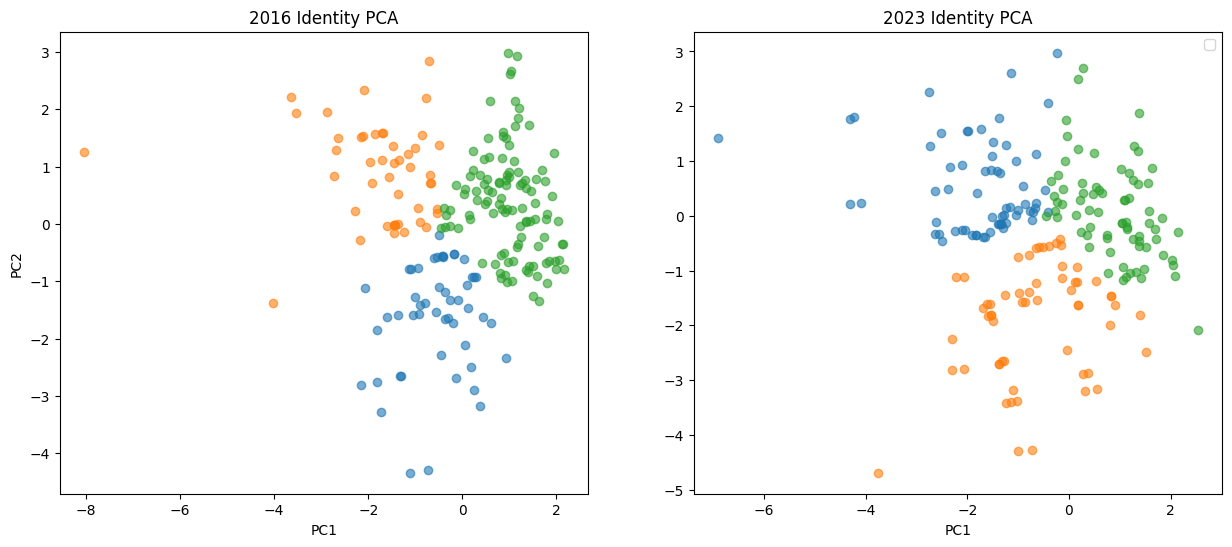

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

# 2016
for c in drives16_pca["cluster"].unique():
    s = drives16_pca[drives16_pca["cluster"] == c]
    ax[0].scatter(s["PC1"], s["PC2"], label=f"C{c}", alpha=0.6)
ax[0].set_title("2016 Identity PCA")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# 2023
for c in drives23_pca["cluster"].unique():
    s = drives23_pca[drives23_pca["cluster"] == c]
    ax[1].scatter(s["PC1"], s["PC2"], alpha=0.6)
ax[1].set_title("2023 Identity PCA")
ax[1].set_xlabel("PC1")

plt.legend()
plt.show()

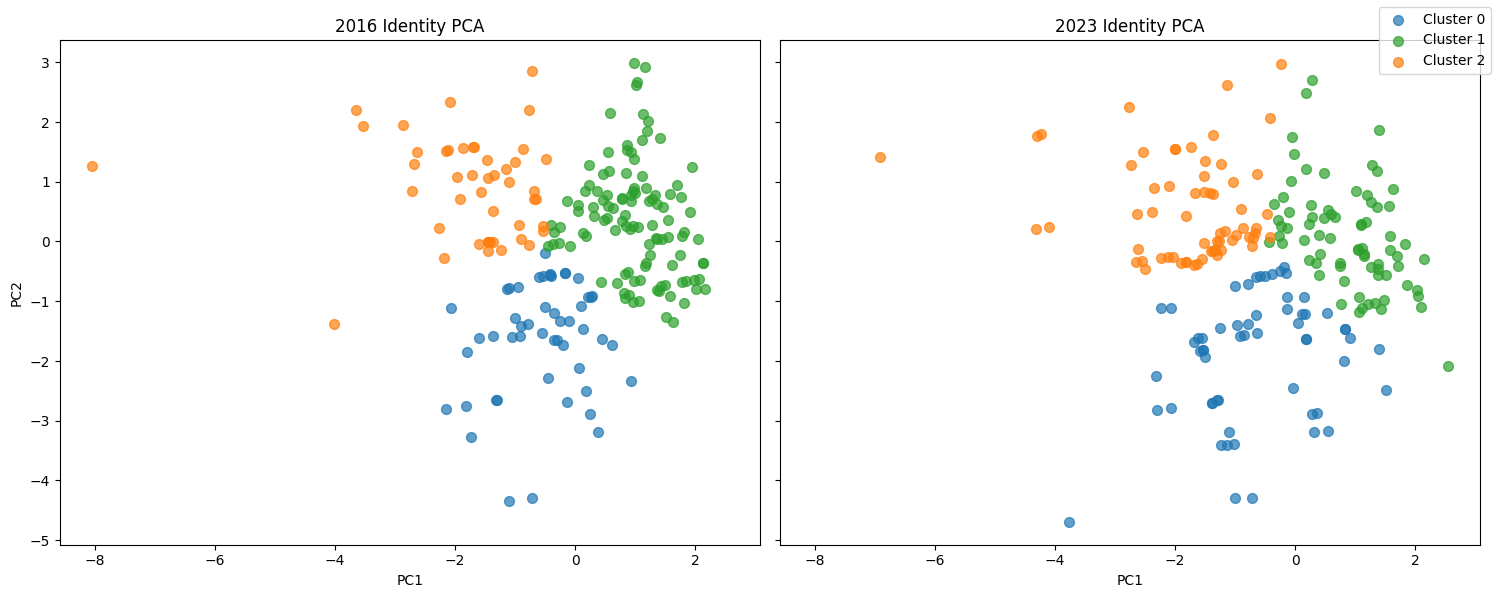

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nice color palette for clusters
palette = {0: "#1f77b4", 1: "#2ca02c", 2: "#ff7f0e"}

fig, ax = plt.subplots(1, 2, figsize=(15,6), sharex=True, sharey=True)

# --- 2016 ---
for c in sorted(drives16_pca["cluster"].unique()):
    subset = drives16_pca[drives16_pca["cluster"] == c]
    ax[0].scatter(
        subset["PC1"], subset["PC2"],
        label=f"Cluster {c}", 
        alpha=0.7, 
        s=50,
        color=palette[c]
    )
ax[0].set_title("2016 Identity PCA")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# --- 2023 ---
for c in sorted(drives23_pca["cluster"].unique()):
    subset = drives23_pca[drives23_pca["cluster"] == c]
    ax[1].scatter(
        subset["PC1"], subset["PC2"],
        alpha=0.7, 
        s=50,
        color=palette[c]
    )
ax[1].set_title("2023 Identity PCA")
ax[1].set_xlabel("PC1")

# Global legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()

In [20]:
print("========== DRIVE-LEVEL FEATURE SUMMARY: 2016 ==========")
print(drives16[['run_pct','pass_pct','success_rate','avg_epa','play_count']].describe())
print("\n")

print("========== DRIVE-LEVEL FEATURE SUMMARY: 2023 ==========")
print(drives23[['run_pct','pass_pct','success_rate','avg_epa','play_count']].describe())
print("\n")

print("========== CLUSTER CENTERS ==========")
centers = clusterer.get_cluster_centers()
print(centers)
print("\n")

print("========== CLUSTER DISTRIBUTION (2016) ==========")
print(drives16['cluster'].value_counts(normalize=True))
print("\n")

print("========== CLUSTER DISTRIBUTION (2023) ==========")
print(drives23['cluster'].value_counts(normalize=True))
print("\n")

print("========== PCA SANITY CHECK: 2016 ==========")
print(drives16_pca[['PC1','PC2','cluster']].head())
print("\n")

print("========== PCA SANITY CHECK: 2023 ==========")
print(drives23_pca[['PC1','PC2','cluster']].head())
print("\n")

print("========== VALIDATION COMPLETE ==========")

========== DRIVE-LEVEL FEATURE SUMMARY: 2016 ==========
          run_pct    pass_pct  success_rate     avg_epa  play_count
count  207.000000  207.000000    207.000000  207.000000  207.000000
mean     0.307962    0.428007      0.443562    0.013053    7.400966
std      0.202903    0.226983      0.245469    0.843524    3.583755
min      0.000000    0.000000      0.000000   -7.666429    1.000000
25%      0.181818    0.275253      0.250000   -0.305637    5.000000
50%      0.333333    0.428571      0.466667    0.043832    7.000000
75%      0.444444    0.555556      0.600000    0.472169   10.000000
max      1.000000    1.000000      1.000000    1.964799   18.000000


========== DRIVE-LEVEL FEATURE SUMMARY: 2023 ==========
          run_pct    pass_pct  success_rate     avg_epa  play_count
count  197.000000  197.000000    197.000000  197.000000  197.000000
mean     0.350589    0.403030      0.334088   -0.299355    7.076142
std      0.223856    0.224593      0.235132    0.831998    3.846452
mi

KeyError: 'cluster'

In [21]:
drives16_clust = clusterer.assign_clusters(drives16)
drives23_clust = clusterer.assign_clusters(drives23)

print("2016 cluster distribution:")
print(drives16_clust["cluster"].value_counts(normalize=True))
print("\n2023 cluster distribution:")
print(drives23_clust["cluster"].value_counts(normalize=True))

2016 cluster distribution:
1    0.531401
0    0.241546
2    0.227053
Name: cluster, dtype: float64

2023 cluster distribution:
1    0.375635
2    0.324873
0    0.299492
Name: cluster, dtype: float64
